# Import Libraries

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Data Preprocessing

In [4]:
df = pd.read_csv("./cleaned_data.csv")  

# Convert DateReported to datetime, sort by date, and set as index
df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
df = df.sort_values("DateReported")
df.set_index("DateReported", inplace=True)

df.head(5)


/var/folders/r9/vr40l1ss0v71ty4xxtt_10j00000gn/T/ipykernel_82206/1070397913.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)


,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,HourReported,ReportingOfficer,InSession,DayOfWeek,TimeOfDay_Adjusted,TimeOfDay
DateReported,,,,,,,,,,,,
2019-10-05 04:48:36+00:00,25111,Animal Complaint,201900028849,NaN,JEFFERSON PARK AVE @ CLEVELAND AVE,CPD,48,"Bise, Collin",1,Saturday,Dusk,Night
2019-10-05 05:13:53+00:00,25110,Animal Complaint,201900028854,NaN,1ST ST S / LANKFORD AVE,CPD,113,"Reed, Patrick",1,Saturday,Dusk,Night
2019-10-05 05:36:03+00:00,25109,Larceny,201900028857,400.0,E MAIN ST,CPD,136,"Babij, Joshua",1,Saturday,Dusk,Night
2019-10-05 06:18:28+00:00,25108,Larceny,201900028865,1500.0,UNIVERSITY AVE,CPD,218,"Bise, Collin",1,Saturday,Dusk,Night
2019-10-05 11:48:08+00:00,25107,Stolen Property Offenses,201900028882,1100.0,AVON ST,CPD,748,"HARPINE, MATTHEW",1,Saturday,Sunrise,Night


## Aggregate daily crime counts

<Axes: xlabel='DateReported'>

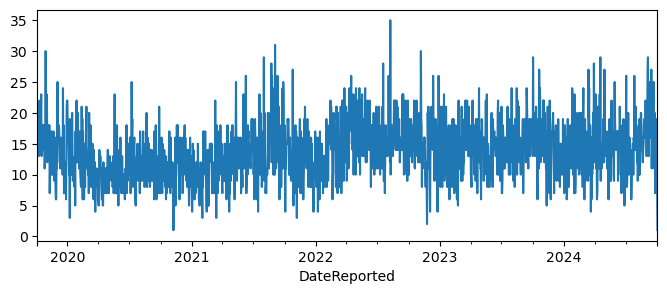

In [37]:

daily_crime_counts = df.resample("D").size()
daily_crime_counts.plot(figsize=(8, 3))

<Axes: ylabel='Count'>

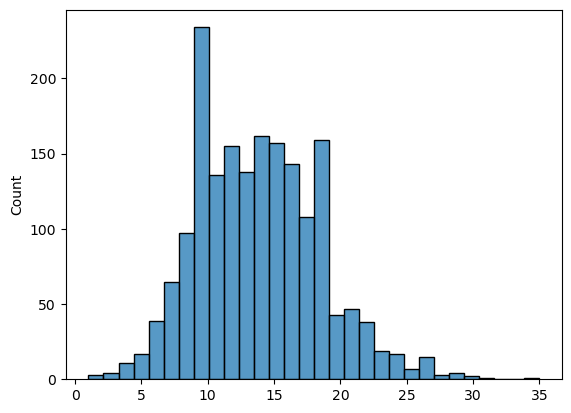

In [45]:
# View distribution of daily crime counts 
sns.histplot(daily_crime_counts)

# Check for Stationarity

In [41]:
adf_test = adfuller(daily_crime_counts)
print(f"ADF Statistic: {adf_test[0]}.")
print(f"p-value: {adf_test[1]}")

if adf_test[1] > 0.05:
    print("The data is not stationary. Differencing may be needed.")
else:
    print("The data is stationary. No differencing needed.")

ADF Statistic: -5.370645108654265.
p-value: 3.902773357106362e-06
The data is stationary. No differencing needed.


# Fit SARIMA Model

## Different m values
m indicates seasonality. 
* m = 4 --> quarterly seasonality 
* m = 7 --> weekly seasonality 
* m = 12 --> monthly seasonality 


### m = 7 (weekly seasonality)

In [42]:
# Dermine optimal SARIMA parameters

# stepwise = True balances accuracy with speed and computational efficiency 
auto_model_m7 = auto_arima(daily_crime_counts, seasonal=True, m=7, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11490.817, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11042.049, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10512.150, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11488.820, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10510.915, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=10512.038, Time=0.28 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=10496.758, Time=0.22 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=10496.264, Time=0.41 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=10488.755, Time=1.15 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=10488.584, Time=2.86 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=4.27 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=i

In [44]:
model_m7 = SARIMAX(daily_crime_counts, 
                 order=(2,1,1), 
                 seasonal_order=(2, 0, 1, 7), 
                 trend = "c")

results_m7 = model_m7.fit(maxiter = 10000) # Use disp=False to hide optimization output

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90212D+00    |proj g|=  2.99219D-01


 This problem is unconstrained.



At iterate    5    f=  2.87345D+00    |proj g|=  4.01070D-02

At iterate   10    f=  2.86945D+00    |proj g|=  9.80660D-03

At iterate   15    f=  2.86944D+00    |proj g|=  6.67243D-03

At iterate   20    f=  2.86929D+00    |proj g|=  3.45079D-02

At iterate   25    f=  2.86892D+00    |proj g|=  4.35484D-02

At iterate   30    f=  2.86869D+00    |proj g|=  7.91547D-03

At iterate   35    f=  2.86867D+00    |proj g|=  8.09688D-04

At iterate   40    f=  2.86866D+00    |proj g|=  2.04257D-03

At iterate   45    f=  2.86866D+00    |proj g|=  2.83736D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     66   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [46]:
results_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1825
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 7)   Log Likelihood               -5235.311
Date:                           Sun, 16 Mar 2025   AIC                          10486.623
Time:                                   17:33:42   BIC                          10530.693
Sample:                               10-05-2019   HQIC                         10502.880
                                    - 10-02-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    4.32e-05      0.001      0.040      0.968      -0.002       0.002
ar.L1          0.1125      0.024      4.637      0.000       0.065       0.160
ar.L2          0.0508      0.023      2.205      0.027       0.006       0.096
ma.L1         -0.9693      0.006   -152.040      0.000      -0.982      -0.957
ar.S.L7        0.7107      0.147      4.832      0.000       0.422       0.999
ar.S.L14       0.0332      0.029      1.129      0.259      -0.024       0.091
ma.S.L7       -0.6684      0.144     -4.652      0.000      -0.950      -0.387
sigma2        18.1965      0.553     32.899      0.000      17.112      19.281
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                68.63
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Make Predictions

<Axes: >

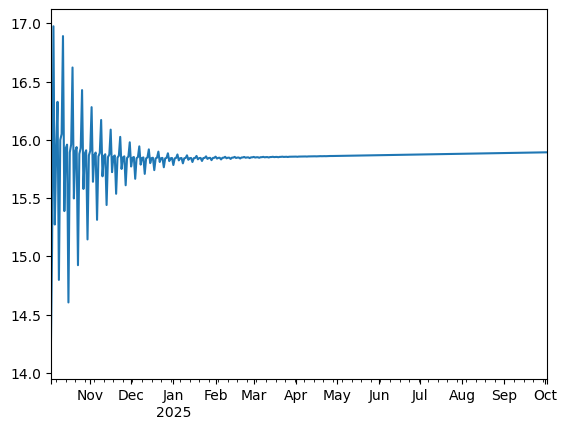

In [47]:
forecast = results_m7.get_forecast(steps=365)  # Forecasts next year (365 days)
forecast_mean = forecast.predicted_mean

forecast_mean.plot()

# Next Steps 

Fix model. 
* Try different values of m (seasonality periods)
* Improve model accuracy (tweak parameters, fix max iterations error)